In [64]:
import torch
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
from captum.robust import FGSM, MinParamPerturbation
from genAdvDataset import genImageNetteConvDict
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [54]:
def viewBatch(model, batch, preprocessor):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    outputs = model(preprocessor(batch).to(device))
    val, idx = torch.max(outputs.logits, dim=1)
    idx = idx.tolist()

    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))  # Create a 4x4 grid of subplots
    axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

    for i, (img, id) in enumerate(zip(batch[:16], idx[:16])):
        img = img.cpu().numpy().transpose((1, 2, 0))  # Convert tensor to numpy and change C, H, W to H, W, C
        img = np.clip(img, 0, 1)  # Ensure pixel values are valid for display
        axes[i].imshow(img)
        labels = model.config.id2label[id]
        axes[i].set_title(f'Classification: {labels.split(",")[0]}')  # Set the title to the label of the image
        axes[i].axis('off')  # Turn off axis numbers and ticks

    plt.tight_layout()  # Adjust layout to make room for titles and ensure plots don't overlap
    plt.show()

In [55]:
def viewTensor(tensor):
    img = tensor.cpu().numpy().transpose((1, 2, 0))  # Convert tensor to numpy and change C, H, W to H, W, C
    img = np.clip(img, 0, 1)  # Ensure pixel values are valid for display
    plt.imshow(img)
    plt.show()

# Load in model, processors and data

In [56]:
def loadModel(modelname):
    model = AutoModelForImageClassification.from_pretrained(modelname).to(device)
    processor = AutoImageProcessor.from_pretrained(modelname)
    
    model.eval()
    torch.no_grad()
    # Strip preprocessing except resize
    processor.do_normalize = False

    normalize = transforms.Normalize(mean=processor.image_mean, std=processor.image_std)

    return model, processor, normalize
    

In [57]:
def bundlerUtil(modelname, suffix):
    loader = lambda x: torch.load(x).squeeze(0)
    data = datasets.DatasetFolder(f'./data_adv_{suffix}', loader=loader, extensions=('.pt',))
    dataLoaderAdvVit = torch.utils.data.DataLoader(data,
                                          batch_size=16,
                                          shuffle=False,
                                          num_workers=0)
    model, processor, normalize = loadModel(modelname)

    return {
        "model": model,
        "processor": processor,
        "normalize": normalize,
        "dataLoader": dataLoaderAdvVit
    }

In [58]:
#def process_image(image):
#    # Note, DataLoader breaks with num_workers > 0 when using processor in transform
#    return processor(image, return_tensors="pt").pixel_values.squeeze(0)

#dataInVal = datasets.ImageFolder('./imagenette/imagenette2/val', transform=transforms.Lambda(process_image))

#dataLoaderInVal = torch.utils.data.DataLoader(dataInVal,
#                                          batch_size=16,
#                                          shuffle=False,
#                                          num_workers=0)

In [59]:

vitBundle = bundlerUtil("google/vit-base-patch16-224", "vit")
resBundle = bundlerUtil("microsoft/resnet-152", "resnet")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


# Verify Attack

In [60]:
def verifyAttack(bundle):
    dataLoader = bundle["dataLoader"]
    model = bundle["model"]
    normalize = bundle["normalize"]
    
    netteToImageNetConv = genImageNetteConvDict(model)

    for inputs, labels in dataLoader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        viewBatch(model, inputs, normalize)
        # Print the true labels:
        reallabels = [model.config.id2label[netteToImageNetConv[label.item()]] for label in labels]
        for label in reallabels:
            print("Real label: ", label)
        break

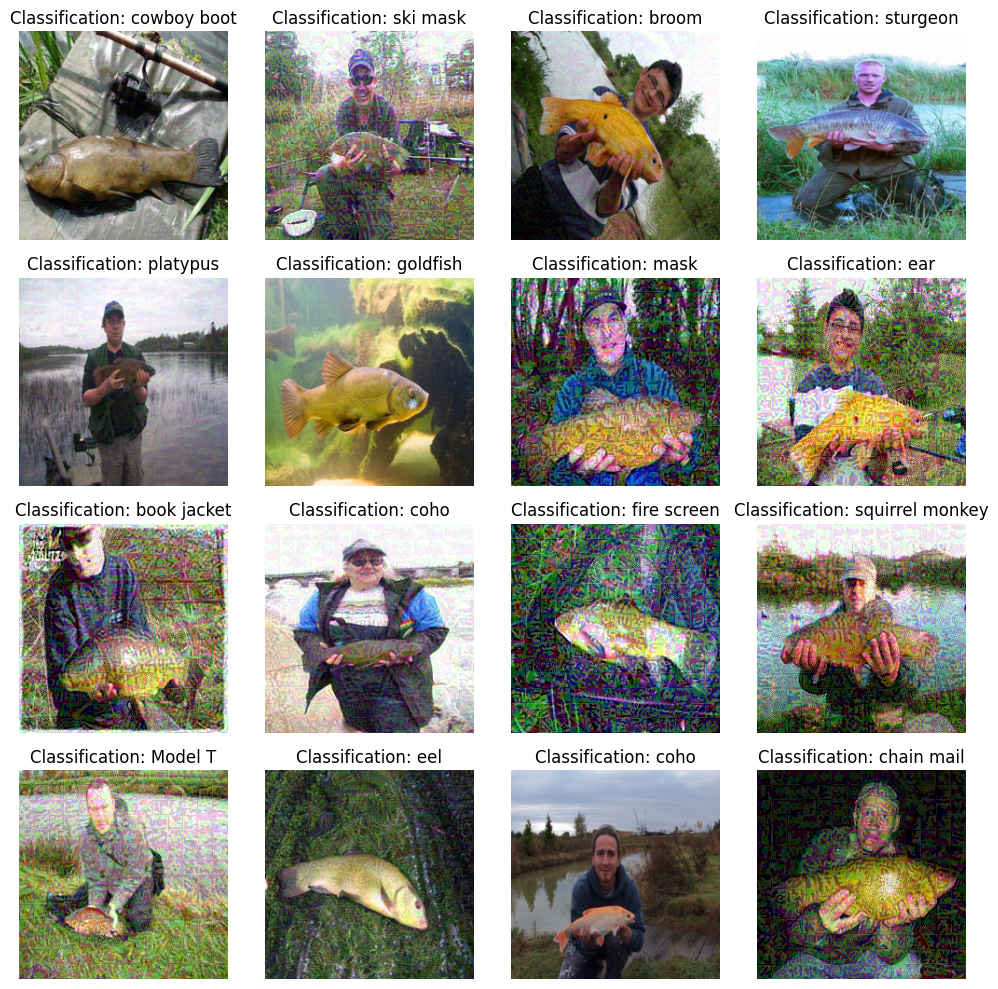

tench, Tinca tinca
tench, Tinca tinca
tench, Tinca tinca
tench, Tinca tinca
tench, Tinca tinca
tench, Tinca tinca
tench, Tinca tinca
tench, Tinca tinca
tench, Tinca tinca
tench, Tinca tinca
tench, Tinca tinca
tench, Tinca tinca
tench, Tinca tinca
tench, Tinca tinca
tench, Tinca tinca
tench, Tinca tinca


In [61]:
verifyAttack(vitBundle)

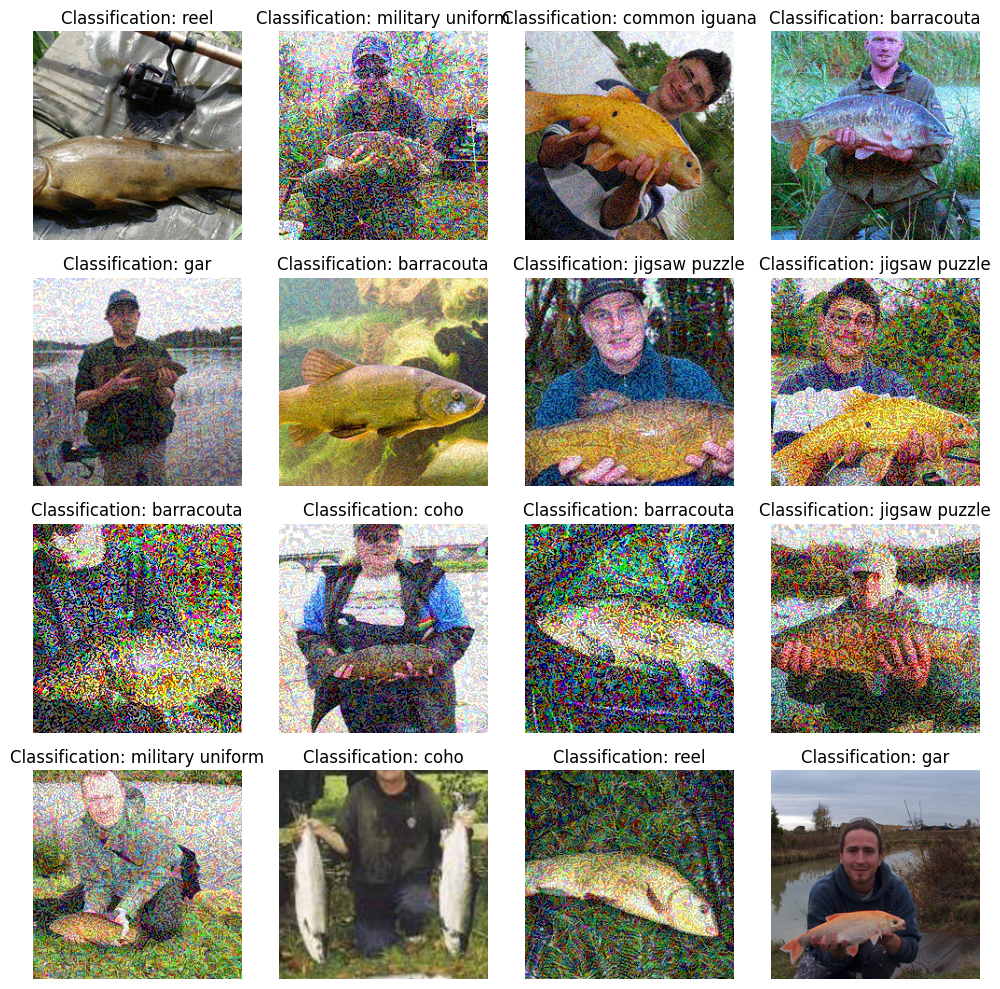

tench, Tinca tinca
tench, Tinca tinca
tench, Tinca tinca
tench, Tinca tinca
tench, Tinca tinca
tench, Tinca tinca
tench, Tinca tinca
tench, Tinca tinca
tench, Tinca tinca
tench, Tinca tinca
tench, Tinca tinca
tench, Tinca tinca
tench, Tinca tinca
tench, Tinca tinca
tench, Tinca tinca
tench, Tinca tinca


In [63]:
verifyAttack(resBundle)

# Robustness Analysis

In [75]:
def robustnessAnalyzer(path):
    # Unpickle the log data
    with open(path, 'rb') as f:
        log = pickle.load(f)

    metrics = list(log[0].keys())[3:]
    aggregatedMetrics = {metric: [] for metric in metrics}
    for metric in metrics:
        aggregatedMetrics[metric] = [entry[metric] for entry in log]

    # Visualize Histograms
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs = axs.flatten()
    for i, (metric, values) in enumerate(aggregatedMetrics.items()):
        axs[i].hist(values, bins=20)
        axs[i].set_title(metric)
    plt.show()

    # Print the mean and std of each metric
    for metric, values in aggregatedMetrics.items():
        print(f"{metric}: {np.mean(values)} +/- {np.std(values)}")

In [69]:
with open("./data_adv_vit/log.pkl", 'rb') as f:
    log = pickle.load(f)

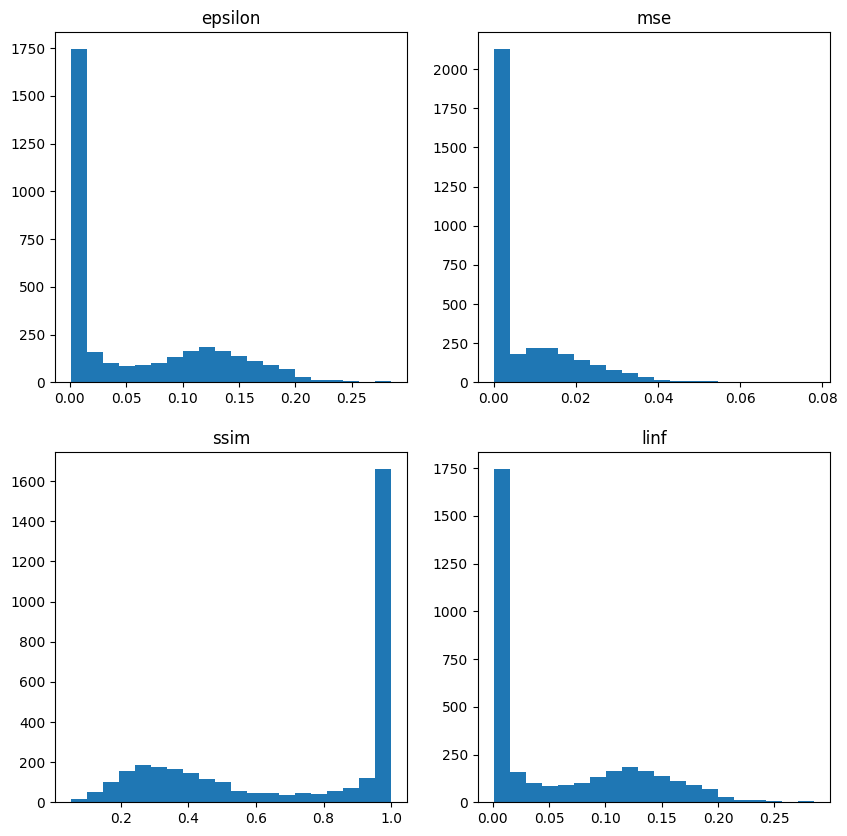

epsilon: 0.05629955947136565 +/- 0.06550823433985807
mse: 0.006955285252889921 +/- 0.01076528611989428
ssim: 0.7185004353523254 +/- 0.3179648816585541
linf: 0.05629957522239629 +/- 0.06550823862245665


In [76]:
robustnessAnalyzer('./data_adv_vit/log.pkl')

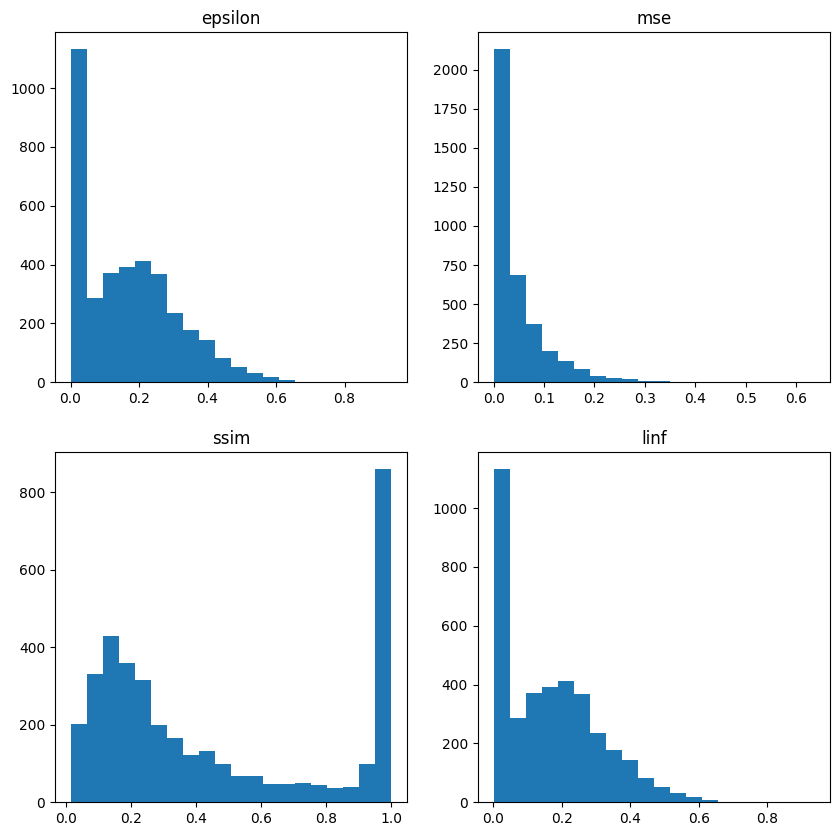

epsilon: 0.1647131324004306 +/- 0.142399737355471
mse: 0.04238792212849784 +/- 0.05602003045636359
ssim: 0.4627467393875122 +/- 0.35394206643104553
linf: 0.16471315399453895 +/- 0.14239974282397252


In [77]:
robustnessAnalyzer('./data_adv_resnet/log.pkl')